# ADAPATION OF SPM'S PREPROCESSING & SINGLE LEVEL ANALYSIS EXAMPLE PIPELINES

The pipelines were adapted on a dataset downloadable [**here**](https://openneuro.org/datasets/ds000114/versions/1.0.1). 

To use the notebooks, create a docker container using the instructions in the file and use the parent repository of **"analytic_variability_fmri"** as a volume. The dataset should be downloaded in a repository named **"tutorial_data"** in the directory **"data"** inside this repository. 
Otherwise, if you want to use different paths, you need to update these paths on the notebooks. 

This notebook is separated into **4 parts** : 
* Preprocessing
* 1st level analysis 
* Normalization
* 2nd level analysis

Only the first part can be ran on its own : other parts need the previous parts to have already been run.

In [1]:
# Set the path to matlab 
## NECESSARY TO USE SPM
from nipype.interfaces import spm
matlab_cmd = '/opt/spm12-r7771/run_spm12.sh /opt/matlabmcr-2010a/v713/ script'
spm.SPMCommand.set_mlab_paths(matlab_cmd=matlab_cmd, use_mcr=True)

In [47]:
from nipype.interfaces.spm import (Realign, SliceTiming, Smooth, Coregister, NewSegment, Normalize12, 
                                    OneSampleTTestDesign, EstimateModel, EstimateContrast, Threshold, 
                                  Level1Design)
from nipype.interfaces.fsl import ExtractROI
from nipype.interfaces.utility import IdentityInterface, Function
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.algorithms.misc import Gunzip
from nipype.interfaces.base import Bunch  
from nipype import Workflow, Node, JoinNode

from nilearn import plotting
%matplotlib inline
from os.path import join as opj
import os
import json

## PREPROCESSING

In [3]:
# REPOSITORIES TO FIND & STORE FILES 
## exp_dir : where the results files will be stored and where the data files are stored
## working_dir : where the intermediate results files will be stored (inside exp_dir)
## output_dir : where the final results files (the one you connect to datasink) will be stored inside exp_dir
exp_dir = '/home/analytic_variability_fmri/data/tutorial_data'
working_dir = 'workingdir_spm'
output_dir = 'datasink_spm'

In [4]:
# BASIC VARIABLES
# list of subject identifiers (to simplify the execution, we decided to use only one subject)
# group analysis will be performed in an other notebook
subject_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

# list of session identifiers
task_list = ['fingerfootlips']

# Smoothing widths to apply
fwhm = 8

# TR of functional images
with open('/home/analytic_variability_fmri/data/tutorial_data/task-fingerfootlips_bold.json', 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']

# Number of slices
N = 30

# Time acquisition
TA = TR - TR/N

# Condition names
condition_names = ['Finger', 'Foot', 'Lips']

# Contrasts
cont01 = ['average',        'T', condition_names, [1/3., 1/3., 1/3.]]
cont02 = ['Finger',         'T', condition_names, [1, 0, 0]]
cont03 = ['Foot',           'T', condition_names, [0, 1, 0]]
cont04 = ['Lips',           'T', condition_names, [0, 0, 1]]
cont05 = ['Finger > others','T', condition_names, [1, -0.5, -0.5]]
cont06 = ['Foot > others',  'T', condition_names, [-0.5, 1, -0.5]]
cont07 = ['Lips > others',  'T', condition_names, [-0.5, -0.5, 1]]

cont08 = ['activation',     'F', [cont02, cont03, cont04]]
cont09 = ['differences',    'F', [cont05, cont06, cont07]]

contrasts = [cont01, cont02, cont03, cont04, cont05, cont06, cont07, cont08, cont09]

In [5]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource")

infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list)]

# SelectFiles - to select necessary files
anat_file = opj('sub-{subject_id}', 'ses-test', 'anat', 'sub-{subject_id}_ses-test_T1w.nii.gz')
func_file = opj('sub-{subject_id}', 'ses-test', 'func',
                'sub-{subject_id}_ses-test_task-{task_name}_bold.nii.gz')

templates = {'anat': anat_file,
             'func': func_file}

selectfiles = Node(SelectFiles(templates,
                               base_directory=exp_dir),
                   name="selectfiles")

In [6]:
# GUNZIP NODE : SPM do not use .nii.gz files
gunzip_func = Node(Gunzip(), name = 'gunzip_func')

gunzip_anat = Node(Gunzip(), name = 'gunzip_anat')

In [7]:
# NODE FOR OUTPUT FILES (store the wanted results in the wanted repository)
datasink = Node(DataSink(base_directory=exp_dir, container=output_dir), name='datasink')

In [8]:
# NODES FOR THE MAIN WORKFLOW 
# ExtractROI - skip dummy scans
extract = Node(ExtractROI(t_min=4, t_size=-1, output_type='NIFTI'),
               name="extract")

## Realignment
realign = Node(Realign(), name='realign')

## Slice timing
slice_timing = Node(SliceTiming(num_slices = N, time_repetition = TR, time_acquisition = TA, 
                                slice_order = [i for i in range(N, 0, -1)], ref_slice = int(N/2)), 
                    name = 'slice_timing')

## Smoothing
smooth = Node(Smooth(fwhm = fwhm), name = 'smooth')

In [10]:
# COREGISTRATION + SEGMENT WORKFLOW TO RUN IN PARALLEL OF OTHER NODES
## Coregistration 
coreg = Node(Coregister(), name = 'coreg')

## Segmentation 
seg = Node(NewSegment(write_deformation_fields = [False, True], 
                      channel_info = (0.0001, 60, (True, True))), name = 'seg')

## Definition of the WorkFlow
coregwf = Workflow(name = 'coregwf')
coregwf.base_dir = opj(exp_dir, working_dir)

## Connection of nodes inside the workflow 
coregwf.connect([(coreg, seg, [('coregistered_source', 'channel_files')])])

In [11]:
# DEFINITION OF THE MAIN WORKFLOW
preprocess = Workflow(name='preprocess')
preprocess.base_dir = opj(exp_dir, working_dir)

# CONNECTION OF NODES INSIDE THE WORKFLOW
preprocess.connect([(infosource, selectfiles, [('subject_id', 'subject_id'), ('task_name', 'task_name')]),
                    (selectfiles, gunzip_func, [('func', 'in_file')]),
                    (selectfiles, gunzip_anat, [('anat', 'in_file')]),
                    (gunzip_func, extract, [('out_file', 'in_file')]),
                    (extract, realign, [('roi_file', 'in_files')]),
                    (realign, slice_timing, [('realigned_files', 'in_files')]),
                    (realign, coregwf, [('mean_image', 'coreg.target')]),
                    (slice_timing, coregwf, [('timecorrected_files', 'coreg.apply_to_files')]),
                    (gunzip_anat, coregwf, [('out_file', 'coreg.source')]),
                    (coregwf, smooth, [('coreg.coregistered_files', 'in_files')]),
                    (realign, datasink, [('realignment_parameters', 'preprocess.parameters')]),
                    (coregwf, datasink, [('seg.transformation_mat', 'preprocess.mat_file'),
                                        ('coreg.coregistered_source', 'preprocess.anat.coregistered')]),
                    (smooth, datasink, [('smoothed_files', 'preprocess.smoothed_files')])
                                       ])

210223-11:14:45,91 nipype.workflow INFO:
	 Generated workflow graph: /home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/preprocess/graph.png (graph2use=colored, simple_form=True).


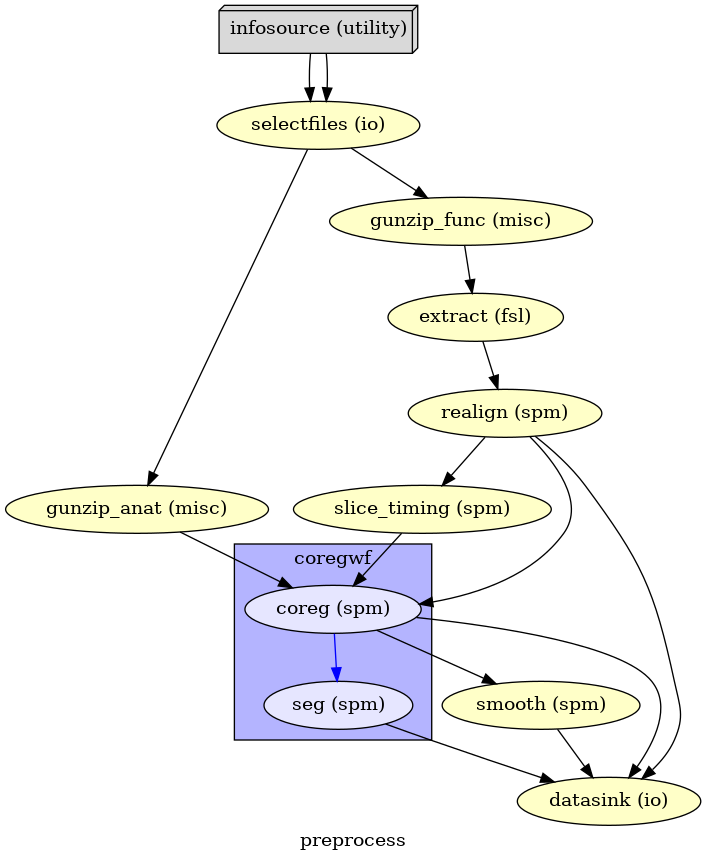

In [12]:
# Create preprocESS output graph
preprocess.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preprocess.base_dir, 'preprocess', 'graph.png'))

In [13]:
preprocess.run('MultiProc', plugin_args={'n_procs': 2})

210223-11:14:45,131 nipype.workflow INFO:
	 Workflow preprocess settings: ['check', 'execution', 'logging', 'monitoring']
210223-11:14:45,191 nipype.workflow INFO:
	 Running in parallel.
210223-11:14:45,196 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 10 jobs ready. Free memory (GB): 13.96/13.96, Free processors: 2/2.
210223-11:14:45,272 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.selectfiles" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/preprocess/_subject_id_09_task_name_fingerfootlips/selectfiles".
210223-11:14:45,278 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
210223-11:14:45,272 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.selectfiles" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/preprocess/_subject_id_10_task_name_fingerfootlips/selectfiles".
210223-11:14:45,285 nipype.workflow INFO:
	 [Node] Finished "preprocess.selectfiles".
210223-11:14:45,289 nipype.w

210223-11:15:35,299 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.slice_timing" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/preprocess/_subject_id_09_task_name_fingerfootlips/slice_timing".
210223-11:15:35,305 nipype.workflow INFO:
	 [Node] Running "slice_timing" ("nipype.interfaces.spm.preprocess.SliceTiming")
210223-11:15:37,247 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 8 jobs ready. Free memory (GB): 13.56/13.96, Free processors: 0/2.
                     Currently running:
                       * preprocess.slice_timing
                       * preprocess.slice_timing
210223-11:15:42,773 nipype.workflow INFO:
	 [Node] Finished "preprocess.slice_timing".
210223-11:15:43,252 nipype.workflow INFO:
	 [Job 5] Completed (preprocess.slice_timing).
210223-11:15:43,253 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 9 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
           

210223-11:18:25,477 nipype.workflow INFO:
	 [Node] Finished "preprocess.selectfiles".
210223-11:18:27,416 nipype.workflow INFO:
	 [Job 20] Completed (preprocess.selectfiles).
210223-11:18:27,418 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 9 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.coregwf.seg
210223-11:18:27,471 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.gunzip_anat" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/preprocess/_subject_id_08_task_name_fingerfootlips/gunzip_anat".
210223-11:18:27,474 nipype.workflow INFO:
	 [Node] Running "gunzip_anat" ("nipype.algorithms.misc.Gunzip")
210223-11:18:27,667 nipype.workflow INFO:
	 [Node] Finished "preprocess.gunzip_anat".
210223-11:18:29,418 nipype.workflow INFO:
	 [Job 21] Completed (preprocess.gunzip_anat).
210223-11:18:29,419 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 8 jobs ready

210223-11:18:47,527 nipype.workflow INFO:
	 [Node] Running "realign" ("nipype.interfaces.spm.preprocess.Realign")
210223-11:18:49,437 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 6 jobs ready. Free memory (GB): 13.56/13.96, Free processors: 0/2.
                     Currently running:
                       * preprocess.realign
                       * preprocess.realign
210223-11:19:10,401 nipype.workflow INFO:
	 [Node] Finished "preprocess.realign".
210223-11:19:11,459 nipype.workflow INFO:
	 [Job 24] Completed (preprocess.realign).
210223-11:19:11,460 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 7 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.realign
210223-11:19:11,515 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.slice_timing" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/preprocess/_subject_id_08_task_name_fingerfootlips/slice_timi

210223-11:22:17,707 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
210223-11:22:17,712 nipype.workflow INFO:
	 [Node] Finished "preprocess.datasink".
210223-11:22:19,647 nipype.workflow INFO:
	 [Job 29] Completed (preprocess.datasink).
210223-11:22:19,649 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 6 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.smooth
210223-11:22:19,709 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.selectfiles" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/preprocess/_subject_id_06_task_name_fingerfootlips/selectfiles".
210223-11:22:19,713 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
210223-11:22:19,718 nipype.workflow INFO:
	 [Node] Finished "preprocess.selectfiles".
210223-11:22:21,649 nipype.workflow INFO:
	 [Job 40] Completed (preprocess.selectf

210223-11:22:39,667 nipype.workflow INFO:
	 [Job 53] Completed (preprocess.extract).
210223-11:22:39,669 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 5 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.realign
210223-11:22:39,731 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.realign" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/preprocess/_subject_id_05_task_name_fingerfootlips/realign".
210223-11:22:39,762 nipype.workflow INFO:
	 [Node] Running "realign" ("nipype.interfaces.spm.preprocess.Realign")
210223-11:22:41,669 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 4 jobs ready. Free memory (GB): 13.56/13.96, Free processors: 0/2.
                     Currently running:
                       * preprocess.realign
                       * preprocess.realign
210223-11:23:08,215 nipype.workflow INFO:
	 [Node] Finished "preprocess.realign".
21022

210223-11:25:33,906 nipype.workflow INFO:
	 [Node] Finished "preprocess.datasink".
210223-11:25:35,842 nipype.workflow INFO:
	 [Job 49] Completed (preprocess.datasink).
210223-11:25:35,843 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 5 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.coregwf.seg
210223-11:25:35,897 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.smooth" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/preprocess/_subject_id_05_task_name_fingerfootlips/smooth".
210223-11:25:35,902 nipype.workflow INFO:
	 [Node] Running "smooth" ("nipype.interfaces.spm.preprocess.Smooth")
210223-11:25:37,844 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 4 jobs ready. Free memory (GB): 13.56/13.96, Free processors: 0/2.
                     Currently running:
                       * preprocess.smooth
                       * preprocess.coregwf.seg


210223-11:26:43,964 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.gunzip_func" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/preprocess/_subject_id_03_task_name_fingerfootlips/gunzip_func".
210223-11:26:43,967 nipype.workflow INFO:
	 [Node] Running "gunzip_func" ("nipype.algorithms.misc.Gunzip")
210223-11:26:44,292 nipype.workflow INFO:
	 [Node] Finished "preprocess.gunzip_func".
210223-11:26:45,912 nipype.workflow INFO:
	 [Job 72] Completed (preprocess.gunzip_func).
210223-11:26:45,914 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 3 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.slice_timing
210223-11:26:45,966 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.extract" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/preprocess/_subject_id_03_task_name_fingerfootlips/extract".
210223-11:26:45,970 nipype.workflow INFO:
	 [Node

210223-11:29:19,462 nipype.workflow INFO:
	 [Node] Finished "preprocess.coregwf.seg".
210223-11:29:20,85 nipype.workflow INFO:
	 [Job 67] Completed (preprocess.coregwf.seg).
210223-11:29:20,87 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 4 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.coregwf.seg
210223-11:29:20,147 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.datasink" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/preprocess/_subject_id_04_task_name_fingerfootlips/datasink".
210223-11:29:20,156 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
210223-11:29:20,161 nipype.workflow INFO:
	 [Node] Finished "preprocess.datasink".
210223-11:29:22,87 nipype.workflow INFO:
	 [Job 69] Completed (preprocess.datasink).
210223-11:29:22,89 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 3 jobs ready. Free memory (GB):

210223-11:30:56,181 nipype.workflow INFO:
	 [Job 77] Completed (preprocess.coregwf.seg).
210223-11:30:56,183 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 2 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.coregwf.coreg
210223-11:30:56,240 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.datasink" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/preprocess/_subject_id_03_task_name_fingerfootlips/datasink".
210223-11:30:56,248 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
210223-11:30:56,253 nipype.workflow INFO:
	 [Node] Finished "preprocess.datasink".
210223-11:30:58,183 nipype.workflow INFO:
	 [Job 79] Completed (preprocess.datasink).
210223-11:30:58,185 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
    

## ANALYSIS 

In [17]:
# SpecifyModel - Generates SPM-specific Model
specify_model = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="specify_model")

# Level1Design - Generates an SPM design matrix
l1design = Node(Level1Design(bases={'hrf': {'derivs': [1, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='FAST'),
                    name="l1design")

# EstimateModel - estimate the parameters of the model
l1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="l1estimate")

# EstimateContrast - estimates contrasts
contrast_estimate = Node(EstimateContrast(), name="contrast_estimate")

In [18]:
def subjectinfo(subject_id):
    '''
    Function to get trial informations (conditions, onsets, durations) from a specific file.
    '''
    import pandas as pd
    from nipype.interfaces.base import Bunch
    
    trialinfo = pd.read_table('/home/analytic_variability_fmri/data/tutorial_data/task-fingerfootlips_events.tsv')
    
    conditions = []
    onsets = []
    durations = []

    for group in trialinfo.groupby('trial_type'):
        conditions.append(group[0])
        onsets.append(list(group[1].onset - 10))
        durations.append(group[1].duration.tolist())

    subject_info = [Bunch(conditions=conditions,
                          onsets=onsets,
                          durations=durations
                         )]

    return subject_info  # this output will later be returned to infosource

In [19]:
# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

In [20]:
# Infosource - a function free node to iterate over the list of subject names
infosource_analysis = Node(IdentityInterface(fields=['subject_id', 'contrasts'],
                                    contrasts=contrasts), 
                           name="infosource")

infosource_analysis.iterables = [('subject_id', subject_list)]

# SelectFiles - to select necessary data 
## func corresponds to smoothed files obtained previously with preprocessing
## mc_param corresponds to motion correction parameters that can be added to the model
templates = {'func': opj(output_dir, 'preprocess', 'smoothed_files','_subject_id_{subject_id}_task_name_{task_id}',
                         'srarsub-{subject_id}_ses-test_task-{task_id}_bold_roi.nii'),
             'mc_param': opj(output_dir, 'preprocess', 'parameters', '_subject_id_{subject_id}_task_name_{task_id}',
                            'rp_sub-{subject_id}_ses-test_task-{task_id}_bold_roi.txt')}

selectfiles_analysis = Node(SelectFiles(templates,
                               base_directory=exp_dir,
                               sort_filelist=True),
                            name="selectfiles")

selectfiles_analysis.inputs.task_id = 'fingerfootlips'

In [21]:
# CREATION OF ANALYSIS WORKFLOW
analysis = Workflow(name = 'analysis')
analysis.base_dir = opj(exp_dir, working_dir)

def make_list(item):
    return [item]

analysis.connect([(infosource_analysis, selectfiles_analysis, [('subject_id', 'subject_id')]),
                  (infosource_analysis, getsubjectinfo, [('subject_id','subject_id')]),
                  (getsubjectinfo, specify_model, [('subject_info', 'subject_info')]),
                  (infosource_analysis, contrast_estimate, [('contrasts', 'contrasts')]),
                  (selectfiles_analysis, specify_model, [('func', 'functional_runs'),
                      ('mc_param', 'realignment_parameters')]),
                  (specify_model, l1design, [('session_info', 'session_info')]),
                  (l1design, l1estimate, [('spm_mat_file', 'spm_mat_file')]),
                  (l1estimate, contrast_estimate, [('spm_mat_file', 'spm_mat_file'),
                      ('beta_images', 'beta_images'),
                      ('residual_image', 'residual_image')]),
                   ])

In [22]:
# Datasink node to save some specific file
datasink_analysis = Node(DataSink(base_directory = exp_dir, container=output_dir), name = 'datasink_analysis')

analysis.connect([(contrast_estimate, datasink_analysis, [('con_images', 'l1analysis.@con_images'),
                                                                   ('spmT_images', 'l1analysis.@spmT_images'),
                                                                   ('spm_mat_file', 'l1analysis.@spm_mat_file')])])

210223-11:35:28,278 nipype.workflow INFO:
	 Generated workflow graph: /home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/analysis/graph.png (graph2use=colored, simple_form=True).


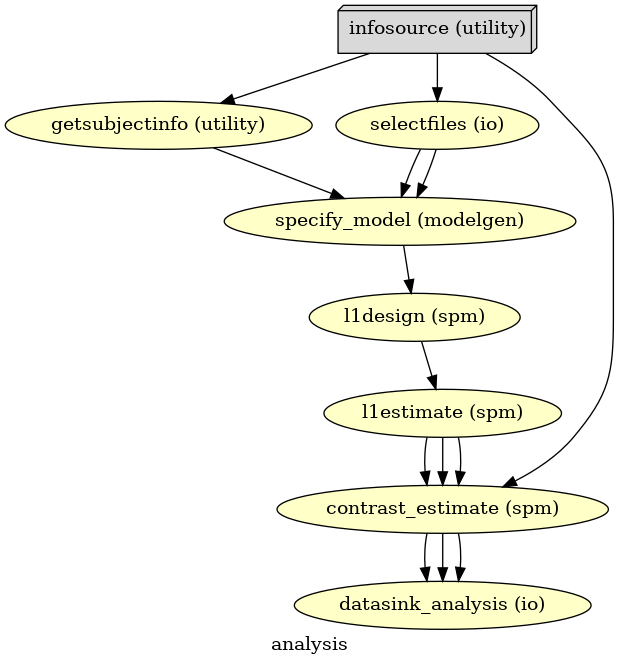

In [23]:
# Create analysis output graph
analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(analysis.base_dir, 'analysis', 'graph.png'))

In [24]:
analysis.run()

210223-11:35:30,949 nipype.workflow INFO:
	 Workflow analysis settings: ['check', 'execution', 'logging', 'monitoring']
210223-11:35:31,5 nipype.workflow INFO:
	 Running serially.
210223-11:35:31,6 nipype.workflow INFO:
	 [Node] Setting-up "analysis.getsubjectinfo" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/analysis/_subject_id_10/getsubjectinfo".
210223-11:35:31,8 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
210223-11:35:31,20 nipype.workflow INFO:
	 [Node] Finished "analysis.getsubjectinfo".
210223-11:35:31,21 nipype.workflow INFO:
	 [Node] Setting-up "analysis.selectfiles" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/analysis/_subject_id_10/selectfiles".
210223-11:35:31,24 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
210223-11:35:31,27 nipype.workflow INFO:
	 [Node] Finished "analysis.selectfiles".
210223-11:35:31,28 nipype.workf

210223-11:36:54,639 nipype.workflow INFO:
	 [Node] Running "datasink_analysis" ("nipype.interfaces.io.DataSink")
210223-11:36:54,644 nipype.workflow INFO:
	 [Node] Finished "analysis.datasink_analysis".
210223-11:36:54,645 nipype.workflow INFO:
	 [Node] Setting-up "analysis.getsubjectinfo" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/analysis/_subject_id_07/getsubjectinfo".
210223-11:36:54,646 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
210223-11:36:54,654 nipype.workflow INFO:
	 [Node] Finished "analysis.getsubjectinfo".
210223-11:36:54,655 nipype.workflow INFO:
	 [Node] Setting-up "analysis.selectfiles" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/analysis/_subject_id_07/selectfiles".
210223-11:36:54,657 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
210223-11:36:54,660 nipype.workflow INFO:
	 [Node] Finished "analysis.selectfiles".


210223-11:38:12,537 nipype.workflow INFO:
	 [Node] Setting-up "analysis.datasink_analysis" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/analysis/_subject_id_05/datasink_analysis".
210223-11:38:12,545 nipype.workflow INFO:
	 [Node] Running "datasink_analysis" ("nipype.interfaces.io.DataSink")
210223-11:38:12,551 nipype.workflow INFO:
	 [Node] Finished "analysis.datasink_analysis".
210223-11:38:12,552 nipype.workflow INFO:
	 [Node] Setting-up "analysis.getsubjectinfo" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/analysis/_subject_id_04/getsubjectinfo".
210223-11:38:12,553 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
210223-11:38:12,561 nipype.workflow INFO:
	 [Node] Finished "analysis.getsubjectinfo".
210223-11:38:12,562 nipype.workflow INFO:
	 [Node] Setting-up "analysis.selectfiles" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/analysis/_subject_id_04/sel

210223-11:39:22,729 nipype.workflow INFO:
	 [Node] Running "contrast_estimate" ("nipype.interfaces.spm.model.EstimateContrast")
210223-11:39:30,531 nipype.workflow INFO:
	 [Node] Finished "analysis.contrast_estimate".
210223-11:39:30,532 nipype.workflow INFO:
	 [Node] Setting-up "analysis.datasink_analysis" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/analysis/_subject_id_02/datasink_analysis".
210223-11:39:30,537 nipype.workflow INFO:
	 [Node] Running "datasink_analysis" ("nipype.interfaces.io.DataSink")
210223-11:39:30,543 nipype.workflow INFO:
	 [Node] Finished "analysis.datasink_analysis".
210223-11:39:30,543 nipype.workflow INFO:
	 [Node] Setting-up "analysis.getsubjectinfo" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/analysis/_subject_id_01/getsubjectinfo".
210223-11:39:30,545 nipype.workflow INFO:
	 [Node] Cached "analysis.getsubjectinfo" - collecting precomputed outputs
210223-11:39:30,546 nipype.workflow INFO:
	 [Node] "analys

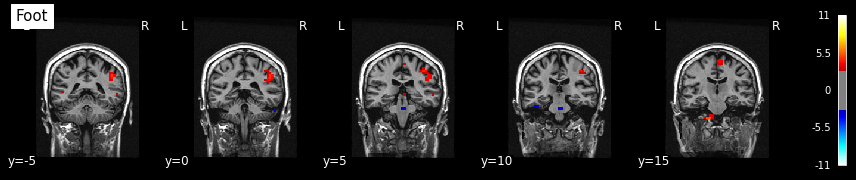

In [33]:
from nilearn.plotting import plot_stat_map
%matplotlib inline
anatimg = '/home/analytic_variability_fmri/data/tutorial_data/sub-01_t1w_preproc.nii.gz'

plot_stat_map('/home/analytic_variability_fmri/data/tutorial_data/datasink_spm/l1analysis/_subject_id_01/con_0002.nii', 
              title='Foot', bg_img=anatimg, threshold=3, display_mode='y', 
              cut_coords=(-5, 0, 5, 10, 15), dim=-1);

In [106]:
# BASIC VARIABLES
# list of subject identifiers (without subject 1, 6 and 10 bc they are left-handed and some tasks activate 
# different regions for left-handed person)
contrast_list = ['02']

subject_list = ['02', '03', '04', '05', '07', '08', '09']

mask = "/home/analytic_variability_fmri/data/tutorial_data/mni_icbm152_nlin_asym_09c/1mm_brainmask.nii.gz"

template = '/opt/spm12-r7771/spm12_mcr/spm12/tpm/TPM.nii'

# Contrast
cont1 = [('Group', 'T', ['mean'], [1])]

In [88]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['contrast_id', 'subject_id']),
                  name="infosource")

infosource.iterables = [('contrast_id', contrast_list), ('subject_id', subject_list)]

# SelectFiles
con_file = opj(output_dir, 'l1analysis', '_subject_id_{subject_id}', "con_00{contrast_id}.nii")

anat_file = 'sub-{subject_id}_t1w_preproc.nii.gz'

templates = {'contrast' : con_file, 'anat' : anat_file}

selectfiles = Node(SelectFiles(templates, base_directory=exp_dir),
                   name="selectfiles")

In [89]:
# Datasink node : to save important files 
datasink = Node(DataSink(base_directory = exp_dir, container = output_dir), name = 'datasink')

In [90]:
gunzip_anat = Node(Gunzip(), name="gunzip_anat")

In [91]:
normalize = Node(Normalize12(jobtype='estwrite',
                             tpm=template,
                             write_voxel_sizes=[1, 1, 1]),
                 name="normalize")

In [92]:
normalization = Workflow(base_dir = opj(exp_dir, working_dir), name = 'normalization')

normalization.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id'), ('subject_id', 'subject_id')]),
                   (selectfiles, gunzip_anat, [('anat', 'in_file')]),
                   (selectfiles, normalize, [('contrast', 'apply_to_files')]),
                   (gunzip_anat, normalize, [('out_file', 'image_to_align')]),
                   (normalize, datasink, [('normalized_files', 'normalized')])
                   ])

210223-13:18:33,418 nipype.workflow INFO:
	 Generated workflow graph: /home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/normalization/graph.png (graph2use=colored, simple_form=True).


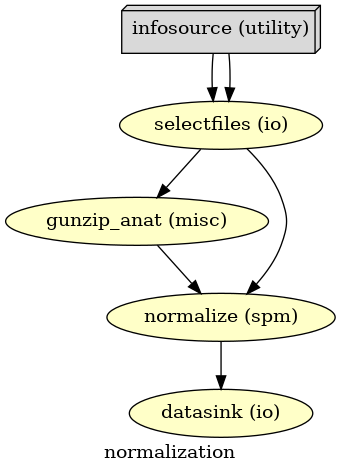

In [93]:
# Create global_analysis output graph
normalization.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(normalization.base_dir, 'normalization', 'graph.png'))

In [69]:
normalization.run('MultiProc', plugin_args={'n_procs': 2})

210223-13:00:37,427 nipype.workflow INFO:
	 Workflow normalization settings: ['check', 'execution', 'logging', 'monitoring']
210223-13:00:37,453 nipype.workflow INFO:
	 Running in parallel.
210223-13:00:37,456 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 7 jobs ready. Free memory (GB): 13.96/13.96, Free processors: 2/2.
210223-13:00:37,548 nipype.workflow INFO:
	 [Node] Setting-up "normalization.selectfiles" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/normalization/_contrast_id_02_subject_id_09/selectfiles".
210223-13:00:37,548 nipype.workflow INFO:
	 [Node] Setting-up "normalization.selectfiles" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/normalization/_contrast_id_02_subject_id_08/selectfiles".
210223-13:00:37,554 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
210223-13:00:37,554 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
210223-13:

210223-13:04:25,764 nipype.workflow INFO:
	 [Node] Finished "normalization.selectfiles".
210223-13:04:27,683 nipype.workflow INFO:
	 [Job 12] Completed (normalization.selectfiles).
210223-13:04:27,684 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 4 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * normalization.normalize
210223-13:04:27,747 nipype.workflow INFO:
	 [Node] Setting-up "normalization.gunzip_anat" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/normalization/_contrast_id_02_subject_id_05/gunzip_anat".
210223-13:04:27,751 nipype.workflow INFO:
	 [Node] Running "gunzip_anat" ("nipype.algorithms.misc.Gunzip")
210223-13:04:28,63 nipype.workflow INFO:
	 [Node] Finished "normalization.gunzip_anat".
210223-13:04:29,685 nipype.workflow INFO:
	 [Job 13] Completed (normalization.gunzip_anat).
210223-13:04:29,687 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 4 jo

210223-13:10:34,50 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * normalization.normalize
210223-13:10:34,116 nipype.workflow INFO:
	 [Node] Setting-up "normalization.selectfiles" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/normalization/_contrast_id_02_subject_id_02/selectfiles".
210223-13:10:34,119 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
210223-13:10:34,122 nipype.workflow INFO:
	 [Node] Finished "normalization.selectfiles".
210223-13:10:36,50 nipype.workflow INFO:
	 [Job 24] Completed (normalization.selectfiles).
210223-13:10:36,52 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * normalization.normalize
210223-13:10:36,109 nipype.w

In [117]:
## Gunzip mask file
gunzip_mask = Node(Gunzip(in_file = mask), name="gunzip_mask")

## Specify design matrix 
one_sample_t_test_design = Node(OneSampleTTestDesign(), name = "one_sample_t_test_design")

## Estimate model 
estimate_model = Node(EstimateModel(estimation_method={'Classical':1}), name = "estimate_model")

## Estimate contrasts
estimate_contrast = Node(EstimateContrast(group_contrast=True, contrasts = cont1), name = "estimate_contrast")

## Create thresholded maps 
threshold = Node(Threshold(contrast_index=1,
                              use_topo_fdr=True,
                              use_fwe_correction=False,
                              extent_threshold=0,
                              height_threshold=0.005,
                              height_threshold_type='p-value',
                              extent_fdr_p_threshold=0.05), name = "threshold")

In [118]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['contrast_id']),
                  name="infosource")

infosource.iterables = [('contrast_id', contrast_list)]

# SelectFiles
con_file = opj(output_dir, 'normalized', '_contrast_id_{contrast_id}_subject_id_*', 
               "wcon_00{contrast_id}.nii")

templates = {'contrast' : con_file}

selectfiles = Node(SelectFiles(templates, base_directory=exp_dir),
                   name="selectfiles")

In [119]:
# Datasink node : to save important files 
datasink = Node(DataSink(base_directory = exp_dir, container = output_dir), name = 'datasink')

In [120]:
l2analysis = Workflow(base_dir = opj(exp_dir, working_dir), name = 'l2analysis')

l2analysis.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id')]),
                   (selectfiles, one_sample_t_test_design, [('contrast', 'in_files')]),
                   (gunzip_mask, one_sample_t_test_design, [('out_file', 'explicit_mask_file')]),
                   (one_sample_t_test_design, estimate_model, [('spm_mat_file', 'spm_mat_file')]),
                   (estimate_model, estimate_contrast, [('spm_mat_file', 'spm_mat_file'),
                                                        ('residual_image', 'residual_image'),
                                                        ('beta_images', 'beta_images')]),
                   (estimate_contrast, threshold, [('spm_mat_file', 'spm_mat_file'),
                                                   ('spmT_images', 'stat_image')]),
                   (estimate_contrast, datasink, [('spm_mat_file', 'l2analysis.@spm_mat'),
                                                   ('spmT_images', 'l2analysis.@T'),
                                                   ('con_images', 'l2analysis.@con')]),
                   (threshold, datasink, [('thresholded_map', 'l2analysis.@threshold')])])

210223-13:24:59,381 nipype.workflow INFO:
	 Generated workflow graph: /home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/l2analysis/graph.png (graph2use=colored, simple_form=True).


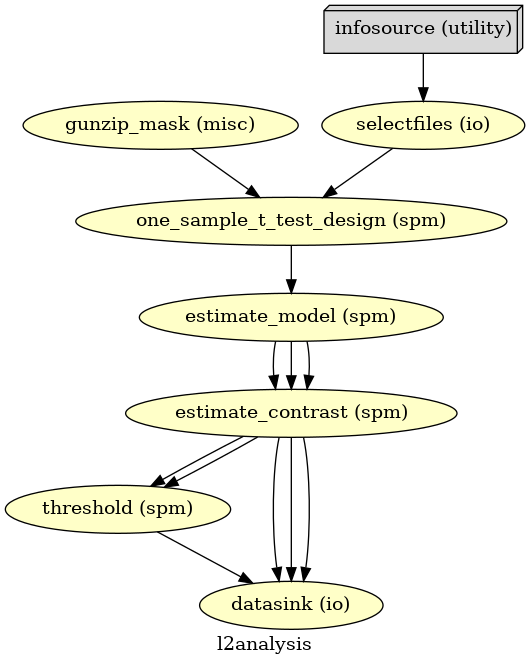

In [121]:
# Create global_analysis output graph
l2analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l2analysis.base_dir, 'l2analysis', 'graph.png'))

In [122]:
l2analysis.run()

210223-13:24:59,924 nipype.workflow INFO:
	 Workflow l2analysis settings: ['check', 'execution', 'logging', 'monitoring']
210223-13:24:59,950 nipype.workflow INFO:
	 Running serially.
210223-13:24:59,951 nipype.workflow INFO:
	 [Node] Setting-up "l2analysis.selectfiles" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/l2analysis/_contrast_id_02/selectfiles".
210223-13:24:59,955 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
210223-13:24:59,958 nipype.workflow INFO:
	 [Node] Finished "l2analysis.selectfiles".
210223-13:24:59,959 nipype.workflow INFO:
	 [Node] Setting-up "l2analysis.gunzip_mask" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_spm/l2analysis/gunzip_mask".
210223-13:24:59,961 nipype.workflow INFO:
	 [Node] Cached "l2analysis.gunzip_mask" - collecting precomputed outputs
210223-13:24:59,961 nipype.workflow INFO:
	 [Node] "l2analysis.gunzip_mask" found cached.
210223-13:24:59,963 nipype.workflo

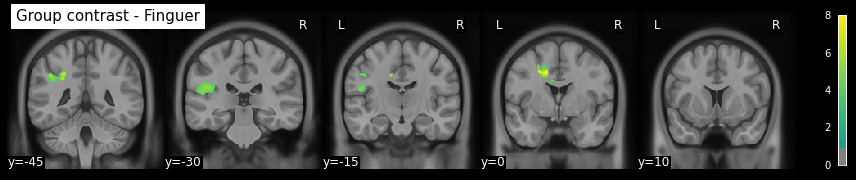

In [129]:
anat_img = '/home/analytic_variability_fmri/data/tutorial_data/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

plot_stat_map(
    '/home/analytic_variability_fmri/data/tutorial_data/datasink_spm/l2analysis/_contrast_id_02/spmT_0001_thr.nii', 
    title='Group contrast - Finger', dim=1, bg_img=anat_img, threshold=1, vmax=8, display_mode='y', 
    cut_coords=(-45, -30, -15, 0, 10), cmap='viridis');